In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamfCR import *

import time

from sklearn.model_selection import KFold

np.random.seed(123)

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/DSM_processed_mono.csv")
gLV_data.head()

,Treatments,Time,CA,BT,BU,CS,CD,DP,CH,BV
0,DSM27147-BT,0.0,0.000000,0.005000,0.000000,0.0,0.005000,0.0,0.0,0.000000
1,DSM27147-BT,12.0,0.000000,1.309089,0.000000,0.0,0.219745,0.0,0.0,0.000000
2,DSM27147-BT,24.0,0.000000,1.069737,0.000000,0.0,0.109763,0.0,0.0,0.000000
3,DSM27147-BT-BU-BV-CA,0.0,0.002000,0.002000,0.002000,0.0,0.002000,0.0,0.0,0.002000
4,DSM27147-BT-BU-BV-CA,12.0,0.010216,1.074319,0.070321,0.0,0.287990,0.0,0.0,0.119654


In [3]:
# get species names
species = list(gLV_data.columns.values[2:])

# Define function to make predictions on test data

In [4]:
# Define function to make predictions on test data

def test(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)
    
    # save true values and predictions
    true = []
    pred = []
    spcs = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])
        
        # predict end-point measured values
        output, _, _ = model.predict(x_test, tspan)
        true.append(output_true[-1])
        pred.append(output[-1, :len(species)])
        # stdv.append(output_stdv[-1, :len(species)])
        spcs.append(species)
        
    return np.concatenate(true), np.concatenate(pred),  np.concatenate(spcs)

# Initialize model parameters

In [5]:
# global parameters 
n_s = len(species)
n_r = 2

# death rate 
d = -3.*np.ones(n_s)

# resource carrying capacity
Kr = np.ones(n_r)

# maximum consumption rate parameters
C = -5.*np.ones([n_r, n_s])
C[0] = -1.

# maximum production rate parameters
P = -5.*np.ones([n_r, n_s])

# efficiency of species / attractiveness of resources
f = np.ones(n_s)

# concatenate parameters 
params = np.concatenate((d, C.flatten(), f))#, P.flatten(), Kr))

# concatenate prior 
Cprior = -5.*np.ones([n_r, n_s])
Pprior = -5.*np.ones([n_r, n_s])
prior = np.concatenate((d, Cprior.flatten(), f))#, Pprior.flatten(), Kr))

n_params = len(params)
n_params

32

In [6]:
C.T

array([[-1., -5.],
       [-1., -5.],
       [-1., -5.],
       [-1., -5.],
       [-1., -5.],
       [-1., -5.],
       [-1., -5.],
       [-1., -5.]])

# Define model

In [7]:
# using consumer resource model  
def system(x, t, params): 
    
    # species 
    s = x[:n_s]
    
    # resources
    r = jnp.exp(x[n_s:])
    
    # death rate
    d = jnp.exp(params[:n_s])
    
    # consumption rate parameters
    C = jnp.exp(np.reshape(params[n_s:n_s+n_r*n_s], [n_r, n_s]))
    
    # efficiency of species
    f = jax.nn.sigmoid(params[n_s+n_r*n_s:n_s+n_r*n_s+n_s])
    
    # production rate parameters
    # P = jnp.exp(np.reshape(params[n_s+n_r*n_s+n_s:n_s+n_r*n_s+n_s+n_r*n_s], [n_r, n_s]))
    # resource carrying capacity 
    # Kr = jnp.exp(params[n_s+n_r*n_s+n_s+n_r*n_s:])
    
    # rate of change of species 
    dsdt = s*(f*(C.T@r) - d) 

    # rate of change of log of resources 
    dlrdt = -C@s # + (P@s)*(1. - r/Kr) 

    return jnp.append(dsdt, dlrdt)

# Define observation matrix

In [8]:
# define observation matrices 
O = np.zeros([n_s, n_s+n_r])
O[:n_s,:n_s] = np.eye(n_s)
O

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

# K-fold cross-validation

In [9]:
# split dataframes according to treatment name 
dfs = [df for name, df in gLV_data.groupby("Treatments")]

# set up Kfold object 
kf = KFold(n_splits = 10)

In [10]:
r0 = np.random.uniform(-3, 0, n_r)
print(r0)

# save true values, test predictions and uncertainty to a dataframe
kfold_df = pd.DataFrame()

for train_ind, test_ind in kf.split(dfs):
    
    # pull train and test data
    train_data = pd.concat([dfs[ind] for ind in train_ind])
    test_data  = pd.concat([dfs[ind] for ind in test_ind])

    # fit model to training data
    model = ODE(system = system, 
                dataframe=train_data,
                cr_params = params, 
                r0 = r0,
                prior = prior,
                species = species,
                alpha_0 = 1e-5,
                verbose=True)

    # fit to data 
    t0 = time.time()
    model.fit(evidence_tol=1e-3, patience=1, max_fails=1)
    print("Elapsed time {:.2f}s".format(time.time()-t0))
    
    # test model 
    true, pred, spcs = test(model, test_data)
    
    # save results
    fold_df = pd.DataFrame()
    fold_df['True'] = true
    fold_df['Pred'] = pred
    fold_df['Spcs'] = spcs
    kfold_df = pd.concat((kfold_df, fold_df))

[-0.91059244 -2.141582  ]
Total samples: 280, Updated regularization: 1.00e-05
Total weighted fitting error: 25.822
Total weighted fitting error: 25.219
Total weighted fitting error: 24.273
Total weighted fitting error: 22.507
Total weighted fitting error: 19.666
Total weighted fitting error: 18.820
Total weighted fitting error: 17.388
Total weighted fitting error: 16.371
Total weighted fitting error: 15.072
Total weighted fitting error: 13.363
Total weighted fitting error: 10.722
Total weighted fitting error: 7.468
Total weighted fitting error: 6.367
Total weighted fitting error: 5.704
Total weighted fitting error: 5.414
Total weighted fitting error: 5.290
Total weighted fitting error: 5.201
Total weighted fitting error: 5.125
Total weighted fitting error: 5.052
Total weighted fitting error: 5.003
Total weighted fitting error: 4.966
Total weighted fitting error: 4.939
Total weighted fitting error: 4.912
Total weighted fitting error: 4.888
Total weighted fitting error: 4.867
Total weig

Total weighted fitting error: 1112.798
Total weighted fitting error: 1112.793
Total weighted fitting error: 1112.788
Total weighted fitting error: 1112.786
Total weighted fitting error: 1112.785
Total weighted fitting error: 1112.782
Total weighted fitting error: 1112.781
Total weighted fitting error: 1112.779
Total weighted fitting error: 1112.778
Total weighted fitting error: 1112.777
Total weighted fitting error: 1112.777
Total weighted fitting error: 1112.775
Total weighted fitting error: 1112.773
Total weighted fitting error: 1112.771
Total weighted fitting error: 1112.767
Total weighted fitting error: 1112.763
Total weighted fitting error: 1112.760
Total weighted fitting error: 1112.760
Total weighted fitting error: 1112.760
Total weighted fitting error: 1112.759
Total weighted fitting error: 1112.758
Total weighted fitting error: 1112.755
Total weighted fitting error: 1112.754
Total weighted fitting error: 1112.753
Total weighted fitting error: 1112.752
Total weighted fitting er

Total weighted fitting error: 1091.504
Evidence 5690.973
Updating precision...
Total samples: 280, Updated regularization: 9.27e-05
Total weighted fitting error: 1116.138
Total weighted fitting error: 1115.857
Total weighted fitting error: 1115.722
Total weighted fitting error: 1115.614
Total weighted fitting error: 1115.577
Total weighted fitting error: 1115.519
Total weighted fitting error: 1115.465
Total weighted fitting error: 1115.377
Total weighted fitting error: 1115.355
Total weighted fitting error: 1115.320
Total weighted fitting error: 1115.267
Total weighted fitting error: 1115.186
Total weighted fitting error: 1115.041
Total weighted fitting error: 1114.889
Total weighted fitting error: 1114.838
Total weighted fitting error: 1114.764
Total weighted fitting error: 1114.733
Total weighted fitting error: 1114.693
Total weighted fitting error: 1114.631
Total weighted fitting error: 1114.519
Total weighted fitting error: 1114.429
Total weighted fitting error: 1114.318
Total weig

Total weighted fitting error: 4.681
Total weighted fitting error: 4.681
Total weighted fitting error: 4.681
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.680
Total weighted fitting error: 4.679
Total weighted fitting error: 4.679
Total weighted fitting error: 4.679
Total weighted fitting error: 4.679
Total weighted fitting error: 4.679
Total weighted fitting error: 4.679
Total weighted fitting error: 4.679
Total weighted fitting error: 4.679
Total weighted fitting error

Total weighted fitting error: 922.616
Total weighted fitting error: 922.054
Total weighted fitting error: 921.908
Total weighted fitting error: 921.710
Total weighted fitting error: 921.486
Total weighted fitting error: 921.275
Total weighted fitting error: 921.115
Total weighted fitting error: 920.950
Total weighted fitting error: 920.786
Total weighted fitting error: 920.681
Total weighted fitting error: 920.586
Total weighted fitting error: 920.507
Total weighted fitting error: 920.401
Total weighted fitting error: 920.330
Total weighted fitting error: 920.213
Total weighted fitting error: 920.051
Total weighted fitting error: 919.972
Total weighted fitting error: 919.926
Total weighted fitting error: 919.888
Total weighted fitting error: 919.832
Total weighted fitting error: 919.787
Total weighted fitting error: 919.749
Total weighted fitting error: 919.698
Total weighted fitting error: 919.670
Total weighted fitting error: 919.625
Total weighted fitting error: 919.560
Total weight

Total weighted fitting error: 4.486
Total weighted fitting error: 4.486
Total weighted fitting error: 4.486
Total weighted fitting error: 4.486
Total weighted fitting error: 4.486
Total weighted fitting error: 4.485
Total weighted fitting error: 4.485
Total weighted fitting error: 4.485
Total weighted fitting error: 4.485
Total weighted fitting error: 4.485
Total weighted fitting error: 4.485
Total weighted fitting error: 4.485
Total weighted fitting error: 4.485
Total weighted fitting error: 4.485
Total weighted fitting error: 4.485
Evidence -148.737
Updating precision...
Total samples: 280, Updated regularization: 3.41e-05
Total weighted fitting error: 276.865
Total weighted fitting error: 276.826
Total weighted fitting error: 276.782
Total weighted fitting error: 276.719
Total weighted fitting error: 276.678
Total weighted fitting error: 276.642
Total weighted fitting error: 276.577
Total weighted fitting error: 276.471
Total weighted fitting error: 276.364
Total weighted fitting er

Total weighted fitting error: 909.092
Total weighted fitting error: 909.090
Total weighted fitting error: 909.089
Total weighted fitting error: 909.089
Evidence 5529.198
Updating precision...
Total samples: 280, Updated regularization: 1.66e-04
Total weighted fitting error: 1102.290
Total weighted fitting error: 1100.651
Total weighted fitting error: 1100.332
Total weighted fitting error: 1099.776
Total weighted fitting error: 1099.137
Total weighted fitting error: 1098.478
Total weighted fitting error: 1098.125
Total weighted fitting error: 1097.644
Total weighted fitting error: 1097.480
Total weighted fitting error: 1097.195
Total weighted fitting error: 1096.926
Total weighted fitting error: 1096.641
Total weighted fitting error: 1096.363
Total weighted fitting error: 1096.220
Total weighted fitting error: 1096.024
Total weighted fitting error: 1095.989
Total weighted fitting error: 1095.921
Total weighted fitting error: 1095.856
Total weighted fitting error: 1095.741
Total weighted

Total weighted fitting error: 4.816
Total weighted fitting error: 4.816
Total weighted fitting error: 4.815
Total weighted fitting error: 4.815
Total weighted fitting error: 4.815
Total weighted fitting error: 4.814
Total weighted fitting error: 4.814
Total weighted fitting error: 4.814
Total weighted fitting error: 4.813
Total weighted fitting error: 4.812
Total weighted fitting error: 4.812
Total weighted fitting error: 4.811
Total weighted fitting error: 4.810
Total weighted fitting error: 4.810
Total weighted fitting error: 4.809
Total weighted fitting error: 4.808
Total weighted fitting error: 4.806
Total weighted fitting error: 4.804
Total weighted fitting error: 4.803
Total weighted fitting error: 4.801
Total weighted fitting error: 4.796
Total weighted fitting error: 4.788
Total weighted fitting error: 4.784
Total weighted fitting error: 4.778
Total weighted fitting error: 4.769
Total weighted fitting error: 4.756
Total weighted fitting error: 4.744
Total weighted fitting error

Total weighted fitting error: 1114.603
Total weighted fitting error: 1112.604
Total weighted fitting error: 1110.614
Total weighted fitting error: 1107.818
Total weighted fitting error: 1106.227
Total weighted fitting error: 1103.676
Total weighted fitting error: 1099.660
Total weighted fitting error: 1093.432
Total weighted fitting error: 1084.082
Total weighted fitting error: 1078.531
Total weighted fitting error: 1069.613
Total weighted fitting error: 1057.983
Total weighted fitting error: 1049.143
Total weighted fitting error: 1046.300
Total weighted fitting error: 1045.308
Total weighted fitting error: 1043.713
Total weighted fitting error: 1042.146
Total weighted fitting error: 1040.617
Total weighted fitting error: 1039.330
Total weighted fitting error: 1038.203
Total weighted fitting error: 1037.781
Total weighted fitting error: 1037.191
Total weighted fitting error: 1036.716
Total weighted fitting error: 1036.298
Total weighted fitting error: 1035.651
Total weighted fitting er

Total weighted fitting error: 827.116
Total weighted fitting error: 826.607
Total weighted fitting error: 826.048
Total weighted fitting error: 825.655
Total weighted fitting error: 825.228
Total weighted fitting error: 824.542
Total weighted fitting error: 823.716
Total weighted fitting error: 823.088
Total weighted fitting error: 820.933
Total weighted fitting error: 819.034
Total weighted fitting error: 816.161
Total weighted fitting error: 814.717
Total weighted fitting error: 812.481
Total weighted fitting error: 810.684
Total weighted fitting error: 810.411
Total weighted fitting error: 810.020
Total weighted fitting error: 809.810
Total weighted fitting error: 809.685
Total weighted fitting error: 809.630
Total weighted fitting error: 809.595
Total weighted fitting error: 809.578
Total weighted fitting error: 809.559
Total weighted fitting error: 809.547
Total weighted fitting error: 809.537
Total weighted fitting error: 809.522
Total weighted fitting error: 809.500
Total weight

Total weighted fitting error: 4.583
Total weighted fitting error: 4.582
Total weighted fitting error: 4.582
Total weighted fitting error: 4.582
Total weighted fitting error: 4.582
Total weighted fitting error: 4.582
Total weighted fitting error: 4.581
Total weighted fitting error: 4.581
Total weighted fitting error: 4.581
Total weighted fitting error: 4.581
Total weighted fitting error: 4.580
Total weighted fitting error: 4.580
Total weighted fitting error: 4.580
Total weighted fitting error: 4.580
Total weighted fitting error: 4.580
Total weighted fitting error: 4.579
Total weighted fitting error: 4.579
Total weighted fitting error: 4.579
Total weighted fitting error: 4.578
Total weighted fitting error: 4.577
Total weighted fitting error: 4.575
Total weighted fitting error: 4.573
Total weighted fitting error: 4.570
Total weighted fitting error: 4.564
Total weighted fitting error: 4.556
Total weighted fitting error: 4.551
Total weighted fitting error: 4.545
Total weighted fitting error

Total weighted fitting error: 1115.907
Total weighted fitting error: 1115.905
Total weighted fitting error: 1115.901
Total weighted fitting error: 1115.896
Total weighted fitting error: 1115.886
Total weighted fitting error: 1115.871
Total weighted fitting error: 1115.860
Total weighted fitting error: 1115.853
Total weighted fitting error: 1115.849
Total weighted fitting error: 1115.842
Total weighted fitting error: 1115.838
Total weighted fitting error: 1115.832
Total weighted fitting error: 1115.823
Total weighted fitting error: 1115.812
Total weighted fitting error: 1115.809
Total weighted fitting error: 1115.804
Total weighted fitting error: 1115.796
Total weighted fitting error: 1115.785
Total weighted fitting error: 1115.774
Total weighted fitting error: 1115.769
Total weighted fitting error: 1115.764
Total weighted fitting error: 1115.759
Total weighted fitting error: 1115.755
Total weighted fitting error: 1115.751
Total weighted fitting error: 1115.747
Total weighted fitting er

Total weighted fitting error: 292.672
Total weighted fitting error: 292.655
Total weighted fitting error: 292.628
Total weighted fitting error: 292.592
Total weighted fitting error: 292.555
Total weighted fitting error: 292.516
Total weighted fitting error: 292.457
Total weighted fitting error: 292.432
Total weighted fitting error: 292.388
Total weighted fitting error: 292.315
Total weighted fitting error: 292.286
Total weighted fitting error: 292.267
Total weighted fitting error: 292.236
Total weighted fitting error: 292.198
Total weighted fitting error: 292.189
Total weighted fitting error: 292.178
Total weighted fitting error: 292.177
Total weighted fitting error: 292.177
Total weighted fitting error: 292.177
Total weighted fitting error: 292.177
Total weighted fitting error: 292.177
Evidence 4397.656
Updating precision...
Total samples: 280, Updated regularization: 3.52e-05
Total weighted fitting error: 1052.267
Total weighted fitting error: 1051.538
Total weighted fitting error: 1

Evidence 5374.203
Updating precision...
Total samples: 280, Updated regularization: 3.77e-05
Total weighted fitting error: 1116.875
Total weighted fitting error: 1116.866
Total weighted fitting error: 1116.862
Total weighted fitting error: 1116.860
Total weighted fitting error: 1116.857
Total weighted fitting error: 1116.855
Total weighted fitting error: 1116.852
Total weighted fitting error: 1116.851
Total weighted fitting error: 1116.849
Total weighted fitting error: 1116.846
Total weighted fitting error: 1116.845
Total weighted fitting error: 1116.844
Total weighted fitting error: 1116.843
Total weighted fitting error: 1116.842
Total weighted fitting error: 1116.841
Total weighted fitting error: 1116.841
Total weighted fitting error: 1116.841
Evidence 5379.964
Updating precision...
Total samples: 280, Updated regularization: 3.77e-05
Total weighted fitting error: 1117.499
Total weighted fitting error: 1117.492
Total weighted fitting error: 1117.492
Total weighted fitting error: 1117

Total weighted fitting error: 1113.712
Total weighted fitting error: 1113.682
Total weighted fitting error: 1113.659
Total weighted fitting error: 1113.634
Total weighted fitting error: 1113.626
Total weighted fitting error: 1113.617
Total weighted fitting error: 1113.605
Total weighted fitting error: 1113.599
Total weighted fitting error: 1113.598
Total weighted fitting error: 1113.596
Total weighted fitting error: 1113.595
Total weighted fitting error: 1113.595
Total weighted fitting error: 1113.595
Evidence 5354.005
Updating precision...
Total samples: 280, Updated regularization: 4.69e-05
Total weighted fitting error: 1116.055
Total weighted fitting error: 1116.049
Total weighted fitting error: 1116.045
Total weighted fitting error: 1116.040
Total weighted fitting error: 1116.038
Total weighted fitting error: 1116.035
Total weighted fitting error: 1116.034
Total weighted fitting error: 1116.033
Total weighted fitting error: 1116.031
Total weighted fitting error: 1116.030
Total weig

Total weighted fitting error: 940.197
Total weighted fitting error: 940.197
Total weighted fitting error: 940.196
Total weighted fitting error: 940.195
Total weighted fitting error: 940.014
NaN gradient, switching to forward sensitivity method!
Evidence 5492.453
Updating precision...
Total samples: 280, Updated regularization: 3.88e-04
Total weighted fitting error: 1101.944
Total weighted fitting error: 1099.224
Total weighted fitting error: 1097.671
Total weighted fitting error: 1096.836
Total weighted fitting error: 1096.084
Total weighted fitting error: 1094.972
Total weighted fitting error: 1094.403
Total weighted fitting error: 1093.646
Total weighted fitting error: 1092.945
Total weighted fitting error: 1091.934
Total weighted fitting error: 1090.912
Total weighted fitting error: 1090.418
Total weighted fitting error: 1089.964
Total weighted fitting error: 1089.876
Total weighted fitting error: 1089.713
Total weighted fitting error: 1089.462
Total weighted fitting error: 1089.037

Total weighted fitting error: 4.656
Total weighted fitting error: 4.656
Total weighted fitting error: 4.656
Total weighted fitting error: 4.656
Total weighted fitting error: 4.656
Total weighted fitting error: 4.656
Total weighted fitting error: 4.656
Total weighted fitting error: 4.656
Total weighted fitting error: 4.656
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error: 4.655
Total weighted fitting error

Total weighted fitting error: 916.320
Total weighted fitting error: 916.269
Total weighted fitting error: 916.174
Total weighted fitting error: 916.009
Total weighted fitting error: 915.898
Total weighted fitting error: 915.720
Total weighted fitting error: 915.430
Total weighted fitting error: 915.098
Total weighted fitting error: 914.795
Total weighted fitting error: 914.570
Total weighted fitting error: 914.221
Total weighted fitting error: 913.761
Total weighted fitting error: 913.544
Total weighted fitting error: 913.512
Total weighted fitting error: 913.508
Total weighted fitting error: 913.505
Total weighted fitting error: 913.502
Total weighted fitting error: 913.495
Total weighted fitting error: 913.485
Total weighted fitting error: 913.477
Total weighted fitting error: 913.474
Total weighted fitting error: 913.471
Total weighted fitting error: 913.469
Total weighted fitting error: 913.467
Total weighted fitting error: 913.465
Total weighted fitting error: 913.465
Total weight

Total weighted fitting error: 3.579
Total weighted fitting error: 3.573
Total weighted fitting error: 3.566
Total weighted fitting error: 3.557
Total weighted fitting error: 3.546
Total weighted fitting error: 3.535
Total weighted fitting error: 3.526
Total weighted fitting error: 3.516
Total weighted fitting error: 3.506
Total weighted fitting error: 3.493
Total weighted fitting error: 3.485
Total weighted fitting error: 3.475
Total weighted fitting error: 3.465
Total weighted fitting error: 3.462
Total weighted fitting error: 3.460
Total weighted fitting error: 3.459
Total weighted fitting error: 3.458
Total weighted fitting error: 3.455
Total weighted fitting error: 3.452
Total weighted fitting error: 3.451
Total weighted fitting error: 3.449
Total weighted fitting error: 3.449
Total weighted fitting error: 3.448
Total weighted fitting error: 3.447
Total weighted fitting error: 3.447
Total weighted fitting error: 3.446
Total weighted fitting error: 3.446
Total weighted fitting error

Total weighted fitting error: 961.254
Total weighted fitting error: 961.249
Total weighted fitting error: 961.247
Total weighted fitting error: 961.247
Total weighted fitting error: 961.245
Total weighted fitting error: 961.244
Total weighted fitting error: 961.243
Total weighted fitting error: 961.242
Total weighted fitting error: 961.241
Total weighted fitting error: 961.238
Total weighted fitting error: 961.235
Total weighted fitting error: 961.232
Total weighted fitting error: 961.230
Total weighted fitting error: 961.228
Total weighted fitting error: 961.228
Total weighted fitting error: 961.227
Total weighted fitting error: 961.226
Total weighted fitting error: 961.224
Total weighted fitting error: 961.222
Total weighted fitting error: 961.220
Total weighted fitting error: 961.220
Total weighted fitting error: 961.219
Total weighted fitting error: 961.219
Total weighted fitting error: 961.217
Total weighted fitting error: 961.216
Total weighted fitting error: 961.216
Total weight

Total weighted fitting error: 966.700
Total weighted fitting error: 966.700
Evidence 4658.741
Pass count  1
Elapsed time 74.25s
Total samples: 162, Updated regularization: 1.00e-05
Total weighted fitting error: 12.804
Total weighted fitting error: 12.676
Total weighted fitting error: 11.453
Total weighted fitting error: 10.447
Total weighted fitting error: 8.894
Total weighted fitting error: 7.292
Total weighted fitting error: 6.747
Total weighted fitting error: 5.769
Total weighted fitting error: 5.102
Total weighted fitting error: 4.691
Total weighted fitting error: 4.445
Total weighted fitting error: 4.378
Total weighted fitting error: 4.350
Total weighted fitting error: 4.304
Total weighted fitting error: 4.234
Total weighted fitting error: 4.159
Total weighted fitting error: 4.104
Total weighted fitting error: 4.053
Total weighted fitting error: 4.035
Total weighted fitting error: 4.004
Total weighted fitting error: 3.956
Total weighted fitting error: 3.936
Total weighted fitting 

Total weighted fitting error: 2.995
Total weighted fitting error: 2.994
Total weighted fitting error: 2.994
Total weighted fitting error: 2.994
Total weighted fitting error: 2.994
Total weighted fitting error: 2.993
Total weighted fitting error: 2.993
Total weighted fitting error: 2.992
Total weighted fitting error: 2.990
Total weighted fitting error: 2.988
Total weighted fitting error: 2.986
Total weighted fitting error: 2.984
Total weighted fitting error: 2.981
Total weighted fitting error: 2.978
Total weighted fitting error: 2.974
Total weighted fitting error: 2.972
Total weighted fitting error: 2.970
Total weighted fitting error: 2.967
Total weighted fitting error: 2.966
Total weighted fitting error: 2.965
Total weighted fitting error: 2.963
Total weighted fitting error: 2.960
Total weighted fitting error: 2.958
Total weighted fitting error: 2.957
Total weighted fitting error: 2.956
Total weighted fitting error: 2.955
Total weighted fitting error: 2.953
Total weighted fitting error

Total weighted fitting error: 90.320
Total weighted fitting error: 90.320
Total weighted fitting error: 90.319
Total weighted fitting error: 90.319
Total weighted fitting error: 90.319
Total weighted fitting error: 90.319
Total weighted fitting error: 90.319
Total weighted fitting error: 90.319
Total weighted fitting error: 90.318
Total weighted fitting error: 90.318
Total weighted fitting error: 90.318
Total weighted fitting error: 90.317
Total weighted fitting error: 90.316
Total weighted fitting error: 90.314
Total weighted fitting error: 90.312
Total weighted fitting error: 90.311
Total weighted fitting error: 90.310
Total weighted fitting error: 90.309
Total weighted fitting error: 90.308
Total weighted fitting error: 90.308
Total weighted fitting error: 90.308
Total weighted fitting error: 90.308
Total weighted fitting error: 90.307
Total weighted fitting error: 90.307
Total weighted fitting error: 90.307
Total weighted fitting error: 90.307
Evidence 2231.201
Updating precision..

Total weighted fitting error: 646.666
Total weighted fitting error: 646.658
Total weighted fitting error: 646.644
Total weighted fitting error: 646.640
Total weighted fitting error: 646.633
Total weighted fitting error: 646.624
Total weighted fitting error: 646.619
Total weighted fitting error: 646.614
Total weighted fitting error: 646.607
Total weighted fitting error: 646.604
Total weighted fitting error: 646.600
Total weighted fitting error: 646.593
Total weighted fitting error: 646.583
Total weighted fitting error: 646.565
Total weighted fitting error: 646.550
Total weighted fitting error: 646.545
Total weighted fitting error: 646.539
Total weighted fitting error: 646.530
Total weighted fitting error: 646.518
Total weighted fitting error: 646.516
Total weighted fitting error: 646.515
Total weighted fitting error: 646.514
Total weighted fitting error: 646.514
Total weighted fitting error: 646.513
Total weighted fitting error: 646.513
Evidence 3333.468
Pass count  1
Elapsed time 65.10

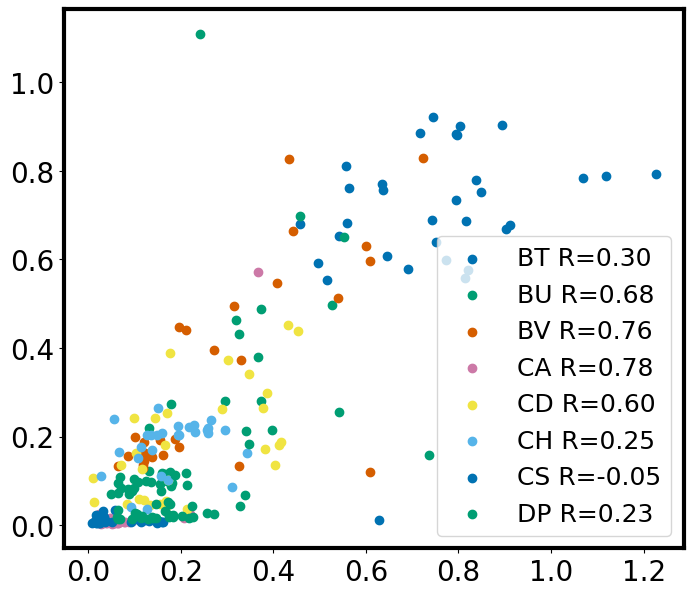

In [11]:
true = kfold_df['True'].values
pred = kfold_df['Pred'].values
spcs = kfold_df['Spcs'].values

for i,sp in enumerate(np.unique(spcs)):
    sp_inds = spcs == sp
    inds_pos = true[sp_inds] > 0
    
    R = linregress(true[sp_inds][inds_pos], pred[sp_inds][inds_pos]).rvalue
    plt.scatter(true[sp_inds][inds_pos], pred[sp_inds][inds_pos], c=f"C{i}", label=sp + " R={:.2f}".format(R))
plt.legend(loc="lower right")
# plt.ylim([0, 1.])
plt.savefig("kfold/CR_kfold.pdf")
plt.show()